In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats as stats
import matplotlib as mpl
import datetime
linewidth_default = 2.0
fig_text_default = 13.
fig_title_default = fig_text_default*1.5

plt.rc('lines', linewidth=linewidth_default)    
plt.rc('text', usetex=False)
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 100

In [238]:
def calc_lag1_autocorrelation(array):
    rho = np.correlate(array,array,'same')/(np.var(array)*np.size(array));
    rho = rho[int(np.size(array)/2):]
    # let the time-lag1 = alpha (autocorrelation magnitude)
    alpha = rho[1]
    return(rho,alpha)

In [2]:
ds = pd.read_csv('SIO_TEMP.csv',skiprows=29,encoding= 'unicode_escape',names=['YEAR','MONTH','DAY','TIME_PST',\
                                                                              'TIME_FLAG','SURF_TEMP_C','SURF_FLAG'\
                                                                              ,'BOT_TEMP_C','BOT_FLAG','empty1','empty2',\
                                                                              'empty3','empty4','empty5'])


In [3]:
# get SST array
mask = (ds['YEAR']>=2015) & (ds['YEAR']<=2020)
sst_raw = ds['SURF_TEMP_C'][mask]
# Fill in NaN's...
sst_corr = sst_raw.copy()
mask = np.isnan(sst_raw)
sst_corr[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), sst_corr[~mask])

# create time array
time = pd.date_range(start="2015-01-01",end="2020-12-31")

In [4]:
count_R=0
count_C=0
for i in np.arange(0,len(time)):
    if np.isnan(np.array(sst_raw)[i]):
        count_R+=1
    if np.isnan(np.array(sst_corr)[i]):
        count_C+=1
print('raw dataset nan count:', count_R)
print('corrected dataset nan count:', count_C)

raw dataset nan count: 259
corrected dataset nan count: 0


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


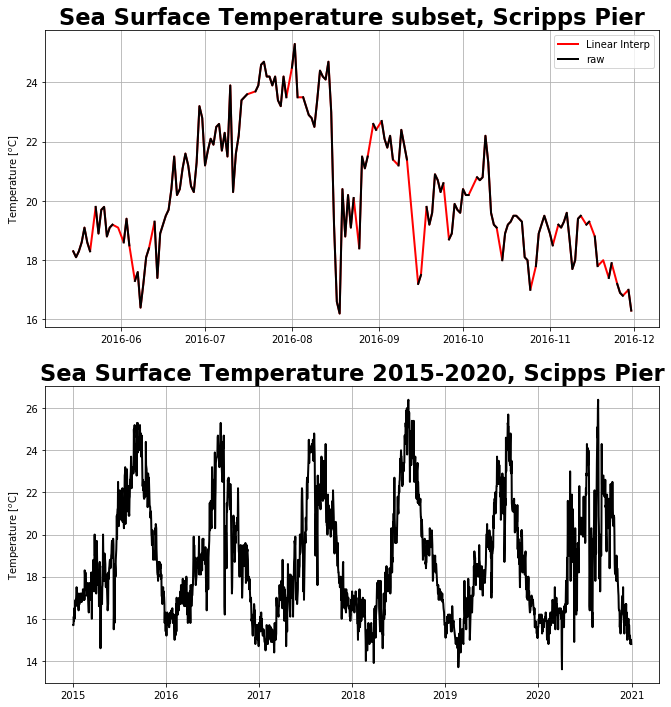

In [5]:
fig = plt.figure(figsize=(11,12))
ax1 = fig.add_subplot(2,1,1)
plt.plot(time[500:700],sst_corr[500:700],label='Linear Interp',color='r')
plt.plot(time[500:700],sst_raw[500:700],label='raw',color='k')
# plt.plot(time[500:700],sst_corr[500:700])
plt.title('Sea Surface Temperature subset, Scripps Pier')
plt.grid();plt.ylabel(r'Temperature [$^o$C]')
plt.legend()
ax2 = fig.add_subplot(2,1,2)
plt.plot(time,sst_corr,color='k')
plt.grid();plt.ylabel(r'Temperature [$^o$C]')
plt.title('Sea Surface Temperature 2015-2020, Scipps Pier')
plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW5/figs/SST_time_series.png',dpi=400,bbox_inches='tight')

### Method A for filtering the seasonal cycle:

Highest power at 6th index


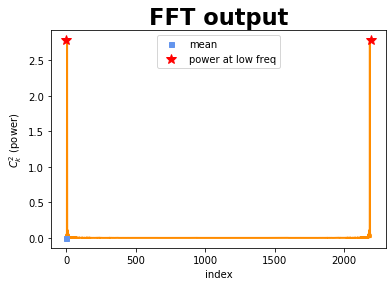

In [6]:
sst_anom = sst_corr - np.mean(sst_corr)

# returned complex ndarray same size as time series array
Z = np.fft.fft(sst_anom)
Yfft = Z/np.size(sst_corr) # symmetric output
# fourier coefficients are symmetric
# power of mean at zero index, power of lowest frequency is the second index = last index,
# third index is power at second lowest freq = second to last index

plt.figure()
plt.plot(np.arange(0,np.size(Yfft)),np.abs(Yfft)**2, color = 'darkorange')
#labels
plt.plot(0,np.abs(Yfft[0])**2.,'s',color = 'cornflowerblue',markersize=5,label='mean')
plt.plot(1,np.abs(Yfft[6])**2.,'*r',markersize=10,label='power at low freq')
plt.plot(np.size(Yfft)-1,np.abs(Yfft[-6])**2.,'*r',markersize=10)

plt.xlabel('index')
plt.ylabel('$C_k^2$ (power)')
plt.title('FFT output')
plt.legend()
# plt.ylim(0,0.5)
print('Highest power at 6th index')

In [7]:
freq = np.arange(0,np.size(sst_corr)/2+1)/float(np.size(sst_anom))
Ck2= 2*np.abs(Yfft[0:int(np.size(sst_anom)/2)+1])**2 # power = 2*normalized fft *

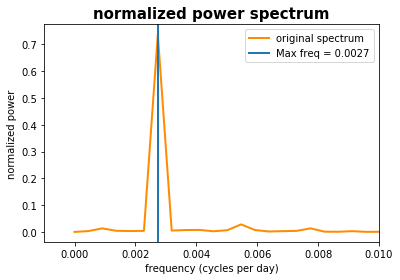

In [8]:
sc_freq_ind = np.argmax(Ck2)
plt.figure()
plt.plot(freq,Ck2/np.sum(Ck2),'-', color = 'darkorange', label = 'original spectrum')
plt.axvline(freq[sc_freq_ind],label='Max freq = 0.0027')
plt.ylabel('normalized power')
plt.xlabel('frequency (cycles per day)')
plt.xlim(-.001,0.01)
plt.title('normalized power spectrum',size=15)
plt.legend()
plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW5/figs/method1_power_spectrum.png',dpi=400,bbox_inches='tight')

In [9]:
print('Max power at Seasonal Cycle at frequency:',freq[sc_freq_ind])

Max power at Seasonal Cycle at frequency: 0.002737226277372263


- We see a max power at the frequency regarding the seasonal cycle. However, this is not within the first three harmonics of the fourier coefficients. This means that there lies some lower frequency oscillation that has power. Perhaps this could be a decadal signal.

In [10]:
# check parsevals theore, the variance compared to total variance in spectrum
# actual variance
var_actual = np.var(sst_anom)
# variance in our spectrum
a = Yfft[np.arange(0,int(np.size(sst_anom)/2)+1)] # get half of symmetric
s = np.sum(a[1::]*np.conj(a[1::])) # sum product of a*conj(a) for all freq except 0 (mean)
var_spectrum = 2*np.real(s)
print('acutal var:',var_actual)
print('spectrum var:',var_spectrum)
# parsevals theorem confirmed

acutal var: 7.537845583096172
spectrum var: 7.537892827814109


In [11]:
numHarm = 7 # chose from looking at power spectrum
# low pass
Zlow = np.copy(Z)
Zlow[numHarm:-(numHarm-1):] = 0 # zero all frequencies except those relating to seasonal cycle
X_lowpass = np.real(np.fft.ifft(Zlow))

# remove seasonal cycle by subtracting lowpass
X_no_sc = sst_anom - X_lowpass

# high pass
Zhigh = np.copy(Z)
Zhigh[0:numHarm:] = 0 # zero lower frequencies
Zhigh[-(numHarm-1)::] = 0.
X_highpass = np.real(np.fft.ifft(Zhigh))

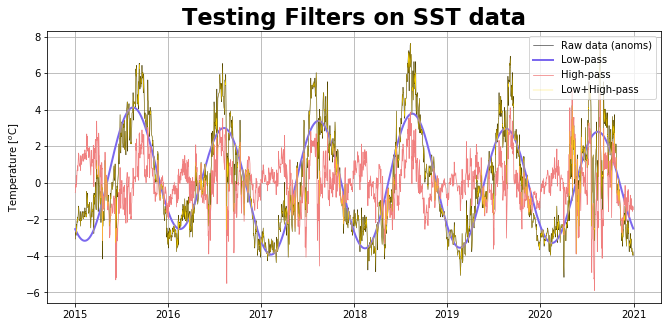

In [12]:
plt.figure(figsize=(11,5))
plt.plot(time,sst_anom,color='black',linewidth=0.5,label='Raw data (anoms)')
plt.plot(time,X_lowpass,color='mediumslateblue',label='Low-pass')
# plt.plot(time,X_no_sc,color='mediumseagreen',label='sst - sc')
plt.plot(time,X_highpass,color='lightcoral',linewidth=0.75,label='High-pass')
plt.plot(time,X_highpass+X_lowpass,color='gold',linewidth=0.3,label='Low+High-pass')
plt.legend();plt.grid()
plt.ylabel(r'Temperature [$^o$C]')
plt.title('Testing Filters on SST data')
plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW5/figs/method1_filter_test.png',dpi=400,bbox_inches='tight')

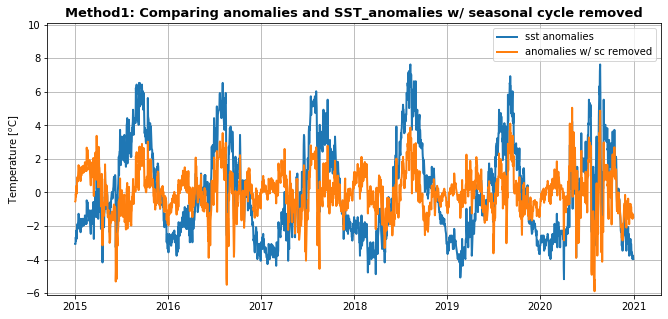

In [13]:
# compare sst_anom and anom time series w/ sc removed
plt.figure(figsize=(11,5))
plt.plot(time,sst_anom,label='sst anomalies')
plt.plot(time,X_no_sc,label='anomalies w/ sc removed')
plt.legend();plt.grid();plt.ylabel(r'Temperature [$^o$C]')
plt.title('Method1: Comparing anomalies and SST_anomalies w/ seasonal cycle removed',size=13);
plt.ylim(-6.1,10.1)
plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW5/figs/method1_remove_sc.png',dpi=400,bbox_inches='tight')

### Looks like the seasonal cycle was removed!

### Method 2 for removing seasonal cycle


In [14]:
# method 2 for removing seasonal cycle
Z = np.fft.fft(sst_anom)
Yfft = Z/np.size(sst_anom)
# grab the harmonic number with as close as possible to 180 days per cycle
# this will grab the seasonal cycle and its second harmonic as well (bi-annual cycle)
numHarm = np.argmin(np.abs(freq-1/182.5))

# OR - high pass filter the data;
Zhigh = np.copy(Z)
Zhigh[0:numHarm:] = 0.
Zhigh[-(numHarm-1)::] = 0.
X_highpass_full = np.real(np.fft.ifft(Zhigh))

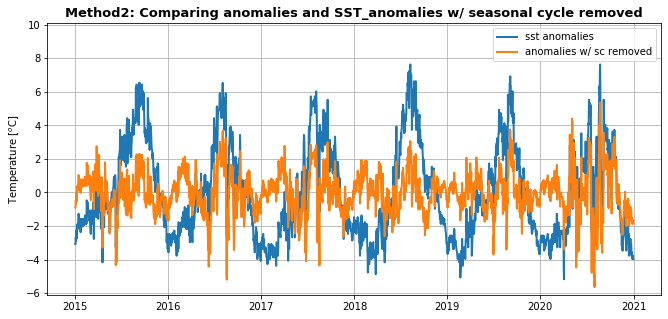

In [15]:
#%% plot raw anomalous time series
plt.figure(figsize=(11,5))
plt.plot(time,sst_anom,label='sst anomalies')
plt.plot(time,X_highpass_full,label='anomalies w/ sc removed')
plt.legend();plt.grid();plt.ylabel(r'Temperature [$^o$C]')
plt.title('Method2: Comparing anomalies and SST_anomalies w/ seasonal cycle removed',size=13);
plt.ylim(-6.1,10.1)
plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW5/figs/method2_remove_sc.png',dpi=400,bbox_inches='tight')

In [16]:
corr = np.corrcoef(X_highpass_full,X_no_sc)[0,1]
print('Correlation between removing seasonal cycle 2 ways: ',corr)

Correlation between removing seasonal cycle 2 ways:  0.9377597218329784


### Problem 2

In [2]:
ds = xr.open_dataset('/Users/tyler/Desktop/SP22/ATS_655/HW5/BEST-1950-2018-monthlyTemp.nc')

ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [199]:
lats1 = np.arange(59.5,90.5,1)
X_nh = ds.sel({'latitude':lats1})
lats2 = np.arange(-59.5,-90.5,-1)
X_sh = ds.sel({'latitude':lats2})
months = np.array(X_nh.time.dt.month)
years = np.array(X_nh.time.dt.year)

nh_mean = np.mean(X_nh.temperature)
sh_mean = np.mean(X_sh.temperature)

In [170]:
T_anoms_nh = np.zeros(len(months))
T_anoms_sh = np.zeros(len(months))

for t in np.arange(0,len(X_nh.time)):
    T_anoms_nh[t] = np.mean(X_nh.temperature[t,:,:] - nh_mean)
    T_anoms_sh[t] = np.mean(X_sh.temperature[t,:,:] - sh_mean)

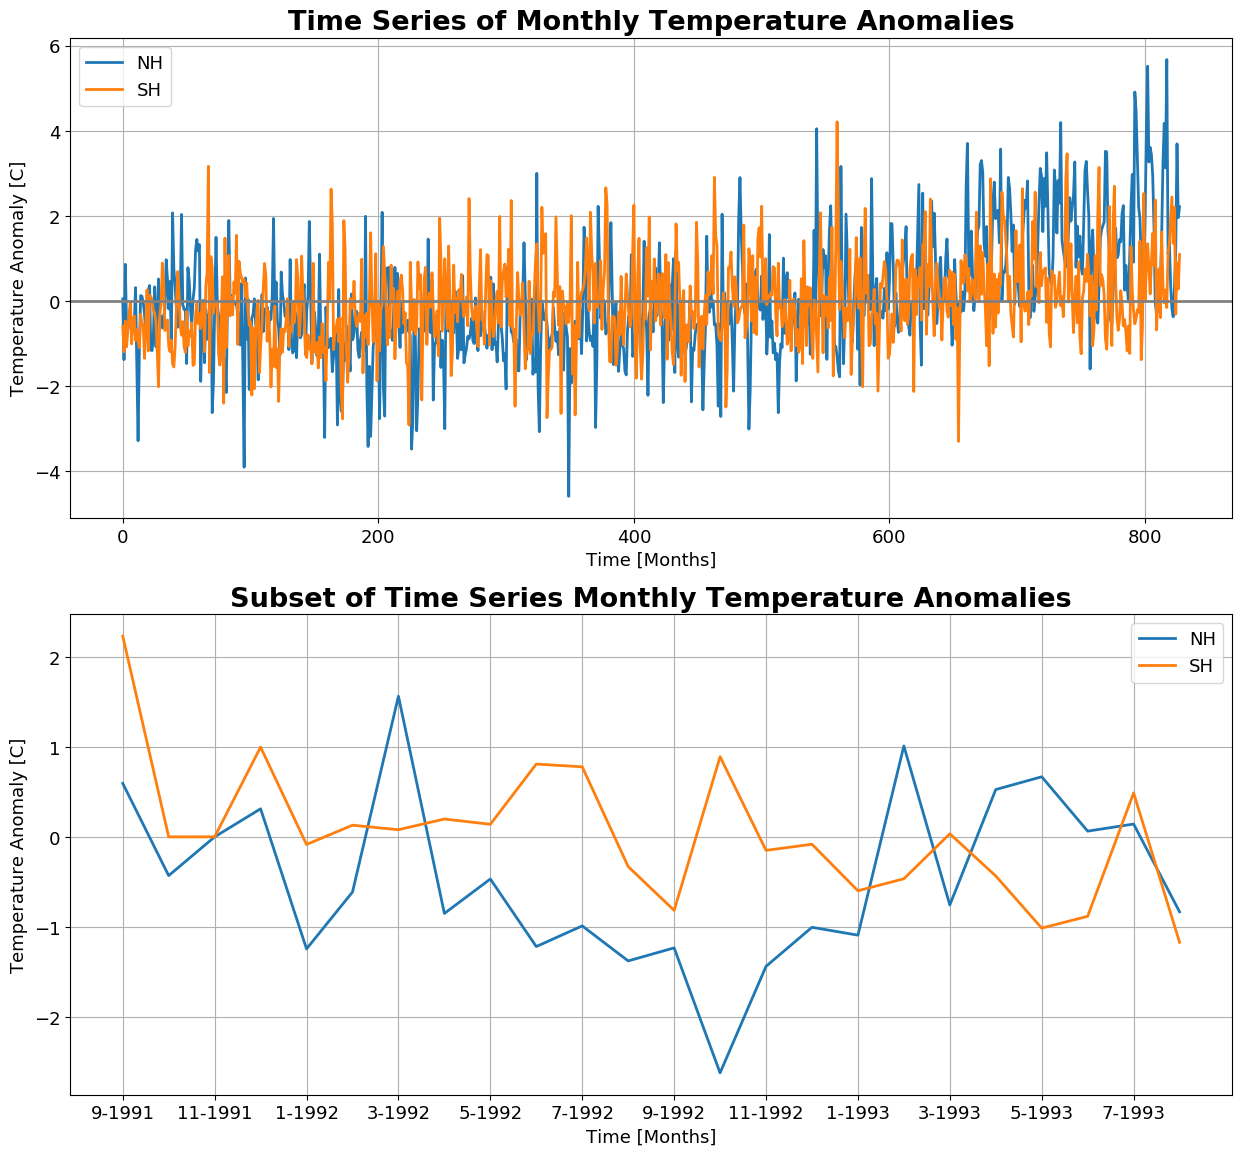

In [231]:
fig = plt.figure(figsize=(15,14))
ax1 = fig.add_subplot(2,1,1)
plt.plot(np.arange(0,len(months)),T_anoms_nh,label='NH')
plt.plot(np.arange(0,len(months)),T_anoms_sh,label='SH')
plt.axhline(0,color='grey')
plt.grid()
plt.title('Time Series of Monthly Temperature Anomalies')
plt.legend()
plt.xlabel('Time [Months]')
plt.ylabel('Temperature Anomaly [C]')

ax1 = fig.add_subplot(2,1,2)
plt.plot(np.arange(500,524),T_anoms_nh[500:524],label='NH')
plt.plot(np.arange(500,524),T_anoms_sh[500:524],label='SH')
plt.xticks(np.arange(500,524,2), [str(months[i])+'-'+str(years[i]) for i in np.arange(500,524,2)])
plt.grid()
plt.title('Subset of Time Series Monthly Temperature Anomalies')
plt.legend()
plt.xlabel('Time [Months]')
plt.ylabel('Temperature Anomaly [C]');
plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW5/figs/TS_Temp_anoms.png',dpi=400,bbox_inches='tight')



(a) Calculate the cross-spectrum between XNH and XSH. Subdivide the data into chunks and average the
separate estimates together to increase your degrees of freedom.

In [370]:
num_chunks= (828 / (chunk_length/2) * 1.2) # 55
# num_chunks = 23

chunk_length = 12*3 # three year
n = int(chunk_length*num_chunks)

In [371]:
rho1, alpha_lag1_1 = calc_lag1_autocorrelation(T_anoms_nh)
rho2, alpha_lag1_2 = calc_lag1_autocorrelation(T_anoms_sh)
print('NH autocorr:',alpha_lag1_1,'SH autocorr:',alpha_lag1_2)
# use lower memory, conservatively

NH autocorr: 0.5802441549531117 SH autocorr: 0.2500090568371544


In [372]:
# # generate red noise time series with autocorrelation
# alpha = alpha_lag1_2
# height = 2.0
# factor = np.sqrt(1.-alpha*alpha)
# Te = -1./np.log(alpha)

# x = np.zeros((n,))
# y = np.zeros((n,))
# pnum = 0

# x[0] = x[-1]*alpha + factor*np.random.randn()
# y[0] = y[-1]*alpha + factor*np.random.randn()
# for j in np.arange(1,n):
#     x[j] = x[j-1]*alpha + factor*np.random.randn()+0.75*np.cos(2.*np.pi*(1.-.001*np.random.randn())*63./256*j-np.pi/4.)
#     y[j] = y[j-1]*alpha + factor*np.random.randn()+0.75*np.cos(2.*np.pi*(1.-.001*np.random.randn())*63./256*j)\
#     +1.0*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*10./256.*j)
# xa = nh_mean - np.mean(nh_mean)
# ya = sh_mean - np.mean(nh_mean)

<Figure size 1100x800 with 0 Axes>

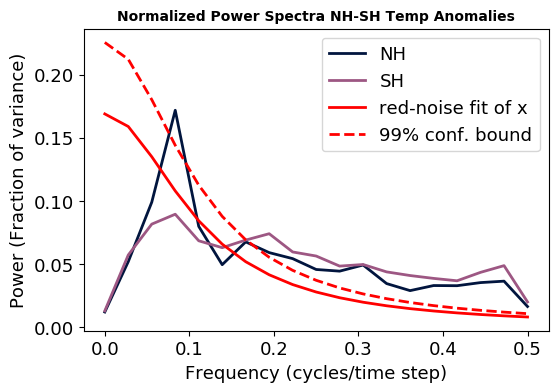

In [373]:
# plot power spectra to see what we're looking at!
fig = plt.figure(figsize=(11,8))
F, Pxx = sig.csd(T_anoms_nh, T_anoms_nh, window = 'hanning', noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = None, scaling = 'density', detrend = 'linear')
F, Pyy = sig.csd(T_anoms_sh, T_anoms_sh, window = 'hanning', noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = None, scaling = 'density', detrend = 'linear')

F, Pxy = sig.csd(T_anoms_nh, T_anoms_sh, window = 'hanning', noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = None, scaling = 'density', detrend = 'linear')

# plot power spectra 
plt.figure()
plt.plot(F,Pxx/np.sum(Pxx),'-', color='xkcd:navy',label = 'NH')
plt.plot(F,Pyy/np.sum(Pyy),'-', color = 'xkcd:light plum', label = 'SH')

plt.title('Normalized Power Spectra NH-SH Temp Anomalies',size=10)
plt.ylabel('Power (Fraction of variance)')
plt.xlabel('Frequency (cycles/time step)')
# calculate and plot red-noise fit of x (and probably y too since they have similar lag-1 autocorrelations)
alpha = sig.correlate(T_anoms_nh,T_anoms_sh,'full')
alpha = alpha/np.max(alpha)
alpha = alpha[int(np.size(alpha)/2)+1]
Te = -1./np.log(alpha)
rnoise = 2.8*2*Te/(1+(Te**2)*(F*2*np.pi)**2)
rnoise = rnoise/np.sum(rnoise)
dof = 2*num_chunks * 1.2 # 1.2 factor for hanning window 
fst = stats.f.ppf(.99,dof,1000)
spec99 = fst*rnoise

# plot red-noise results
plt.plot(F,rnoise,'-',color = 'red', label = 'red-noise fit of x')
plt.plot(F,spec99,'--',color = 'red', label = '99% conf. bound')
plt.legend()
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW5/figs/Power_spectrum_TS_anom.png',dpi=400,bbox_inches='tight')



In [374]:
# NH significant freq
ind = np.argmax(Pxx)
F[ind]
# SH significant freq
ind = np.argmax(Pyy)
F[ind]

0.08333333333333333

Do the cross-specturm analysis

In [375]:
# use an overlap of 0.5

# calculate the squared coherence of x and y
F, Cxy = sig.coherence(T_anoms_nh, T_anoms_sh, window = 'hanning', noverlap = chunk_length/2, nperseg = chunk_length, \
                       nfft = None, detrend = 'linear')

#--------------------------------------------------------------------------------------------------------------
# check that we understand scipy's sig.coherence code by calculating the
# coherence ourselves

#   calculate the cross-spectrum (both real and imaginary parts; i.e. Fxy)
F, Pxy = sig.csd(T_anoms_nh, T_anoms_sh, window = 'hanning', noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = None, scaling = 'density', detrend = 'linear')
F, Pxx = sig.csd(T_anoms_nh,T_anoms_nh, window = 'hanning', noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = None, scaling = 'density', detrend = 'linear')
F, Pyy = sig.csd(T_anoms_sh,T_anoms_sh, window = 'hanning', noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = None, scaling = 'density', detrend = 'linear')
CoherCheck = (np.abs(Pxy)**2)/(Pxx*Pyy)

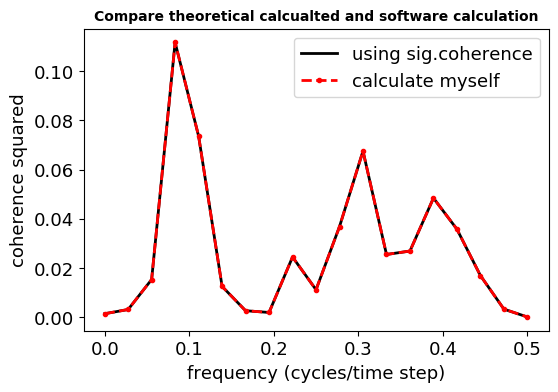

In [376]:
plt.figure()
plt.plot(F,Cxy,'-k',linewidth = 2, label='using sig.coherence')
plt.plot(F,CoherCheck,'.--r',linewidth = 2,label='calculate myself')
plt.title('Compare theoretical calcualted and software calculation',size=10)
plt.ylabel('coherence squared')
plt.xlabel('frequency (cycles/time step)')
plt.legend()
plt.show()

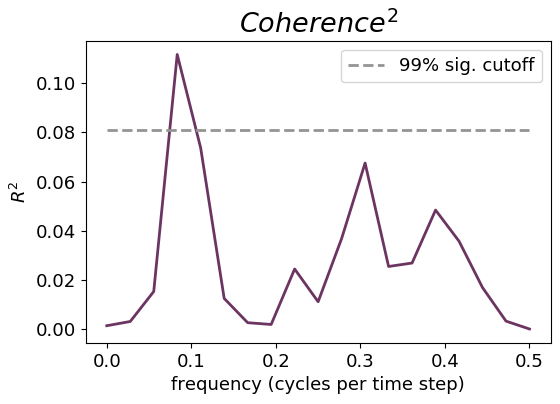

In [377]:
# sort the peaks from largest to smallest to analyze later
j = np.argsort(Cxy)[::-1]

# calculate the squared coherence of x and y
F, Cxy = sig.coherence(T_anoms_nh,T_anoms_sh, window = 'hanning', noverlap = chunk_length/2, nperseg = chunk_length, \
                       nfft = None, detrend = 'linear')
plt.plot(F, Cxy, '-', color='xkcd:grape', linewidth=2)

plt.ylabel('$R^2$')
plt.xlabel('frequency (cycles per time step)')
plt.title('$Coherence^2$')

# determine coherence-squared significance
# num_chunks = 5
dof = 2*num_chunks*1.2
fval = stats.f.ppf(0.99, 2, dof - 2)
r2_cutoff = fval / (num_chunks - 1. + fval)
plt.plot(F,np.ones(np.size(F))*r2_cutoff,'--',\
         color = 'xkcd:grey',linewidth = 2, \
         label = '99% sig. cutoff')
plt.legend()
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW5/figs/Coherence.png',dpi=400,bbox_inches='tight')



In [378]:
# which frequencies surpass 99% cutoff
F[Cxy > r2_cutoff]

array([0.08333333])

In [384]:
print('Degrees of freedom:',dof)

Degrees of freedom: 132.48


-------------------------------------
-162.80253942939476


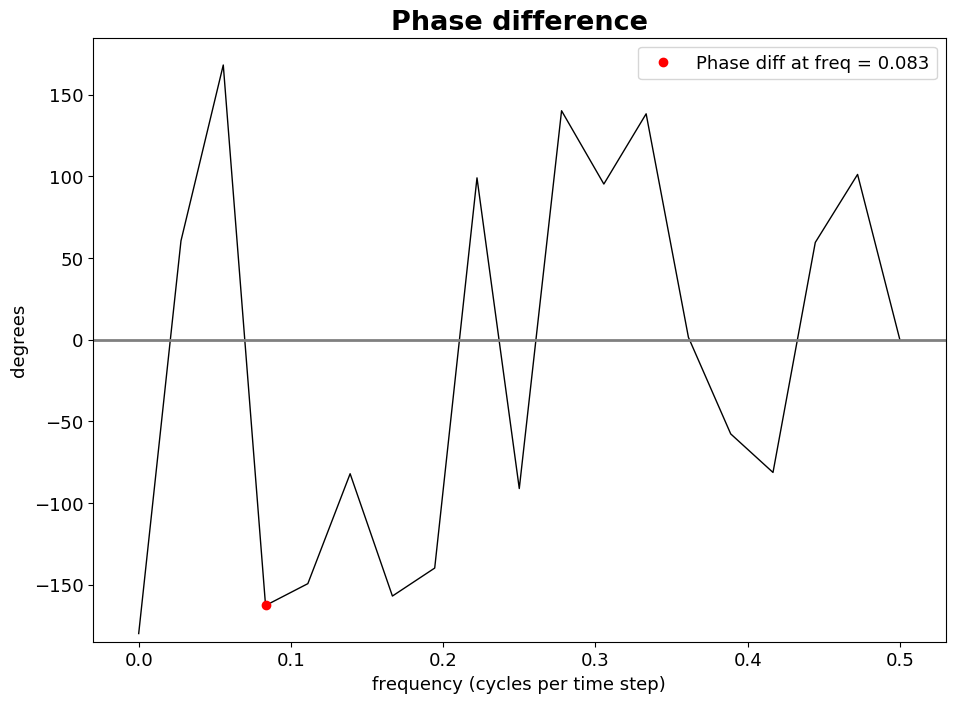

In [411]:
# caculate the quadrature spectrum (phase)
MS=7
P = -np.angle(Pxy, deg = True)
fig = plt.figure(figsize=(11,8))

#%% plot the quadrature spectrum
# plt.figure(figsize=(6,2.5))
plt.plot(F,P,'-k',linewidth = 1)
plt.plot(F[3],P[3],'or',label='Phase diff at freq = 0.083')
# plt.plot(F[j[0]],P[j[0]],'or',linewidth = 1,markersize = MS)
# plt.plot(F[j[1]],P[j[1]],'ob',linewidth = 1,markersize = MS)
plt.legend()
plt.title('Phase difference')
plt.ylabel('degrees')
plt.xlabel('frequency (cycles per time step)')
plt.xlim(-.03,.53)
plt.ylim(-185,185)
plt.axhline(y=0,color='gray')
plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW5/figs/Phase_difference.png',dpi=400,bbox_inches='tight')
print('-------------------------------------')
print(P[3])